In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import backend as K
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential, Model
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Dropout, Bidirectional, Input, Lambda, Dense
from keras.layers.convolutional import Conv1D, MaxPooling1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping

# Initialize session
sess = tf.Session()
K.set_session(sess)

Using TensorFlow backend.


In [ ]:
def plot_charts(history):
    """It shows the Model's accuracy and loss function

    Parameters:
    history (tensorflow.python.keras.callbacks.History): After fitting the model, it keeps the data about it.

    Returns: None

   """
    # Plot the Accuracy and Loss Function
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])

    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])

    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.show()

In [ ]:
df = pd.read_csv('df_prep.csv')

df = df.drop('Unnamed: 0', axis=1)
df.head()
df.shape

(3600, 2)

In [ ]:
X = df.data
Y = pd.get_dummies(df['section']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (3600, 6)


In [ ]:
X.shape

(3600,)

In [ ]:
Y

array([[1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1]], dtype=uint8)

In [ ]:
# Split the data as train and test data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2880,)
(720,)
(2880, 6)
(720, 6)


In [ ]:
# Create datasets (Only take up to 150 words for memory)
train_text = X_train.tolist()
train_text = [' '.join(t.split()[0:100]) for t in train_text]
train_text = np.array(train_text, dtype=object)[:, np.newaxis]
train_label = y_train.tolist()

test_text = X_test.tolist()
test_text = [' '.join(t.split()[0:100]) for t in test_text]
test_text = np.array(test_text, dtype=object)[:, np.newaxis]
test_label = y_test.tolist()

In [ ]:
elmo_model = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)
sess.run(tf.global_variables_initializer())
sess.run(tf.tables_initializer())

In [ ]:
embeddings = elmo_model(X_train, signature="default", as_dict=True)["elmo"]

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [ ]:
embeddings.shape

TensorShape([Dimension(2880), Dimension(2250), Dimension(1024)])

In [ ]:
# Build our model

# We create a function to integrate the tensorflow model with a Keras model
# This requires explicitly casting the tensor to a string, because of a Keras quirk
def ElmoEmbedding(x):
  return elmo_model(tf.reshape(tf.cast(x, tf.string), [-1]), signature="default", as_dict=True)["default"]

 
input_text = Input(shape=(1,), dtype="string", name="Input_Query")
embedding = Lambda(ElmoEmbedding, output_shape=(1024, ), name="Elmo_Embedding")(input_text)
x = Dense(7200, activation='relu')(embedding)
x = Dropout(0.5)(x)
x = Dense(3600, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(6, activation='sigmoid')(x)
model = Model(inputs=[input_text], outputs=outputs, name="tbd")
model.summary()
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Query (InputLayer)     (None, 1)                 0         
_________________________________________________________________
Elmo_Embedding (Lambda)      (None, 1024)              0         
_________________________________________________________________
dense_28 (Dense)             (None, 7200)              7380000   
_________________________________________________________________
dropout_19 (Dropout)         (None, 7200)              0         
_________________________________________________________________
dense_29 (Dense)             (None, 3600)              25923600  
_________________________________________________________________
dropout_20 (Dropout)         (None, 3600)              0         
_________________________________________________________________
dense_30 (Dense)             (None, 6)                 21606     
Total para

In [ ]:
# Fit!
history = model.fit(np.array(train_text), 
          np.array(train_label),
          epochs=8,
          batch_size=64,
          validation_split=0.2)

Train on 2304 samples, validate on 576 samples
Epoch 1/8
2304/2304 [==============================] - 36s 16ms/step - loss: 0.7788 - acc: 0.8079 - val_loss: 0.4416 - val_acc: 0.8339
Epoch 2/8
2304/2304 [==============================] - 32s 14ms/step - loss: 0.4356 - acc: 0.8354 - val_loss: 0.4108 - val_acc: 0.8356
Epoch 3/8
2304/2304 [==============================] - 31s 14ms/step - loss: 0.4098 - acc: 0.8390 - val_loss: 0.3764 - val_acc: 0.8501
Epoch 4/8
2304/2304 [==============================] - 32s 14ms/step - loss: 0.3898 - acc: 0.8452 - val_loss: 0.3699 - val_acc: 0.8487
Epoch 5/8
2304/2304 [==============================] - 31s 14ms/step - loss: 0.3743 - acc: 0.8511 - val_loss: 0.3586 - val_acc: 0.8571
Epoch 6/8
2304/2304 [==============================] - 31s 14ms/step - loss: 0.3601 - acc: 0.8545 - val_loss: 0.3368 - val_acc: 0.8657
Epoch 7/8
2304/2304 [==============================] - 32s 14ms/step - loss: 0.3418 - acc: 0.8624 - val_loss: 0.3102 - val_acc: 0.8747
Epoch 8/

In [ ]:
score = model.evaluate(np.array(test_text), np.array(test_label))

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

720/720 [==============================] - 10s 13ms/step
Test Score: 0.32071706851323445
Test Accuracy: 0.8784722063276503


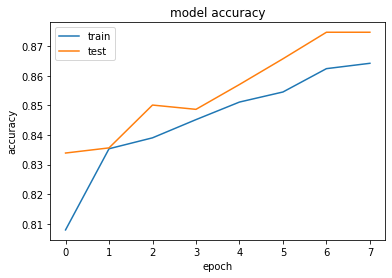

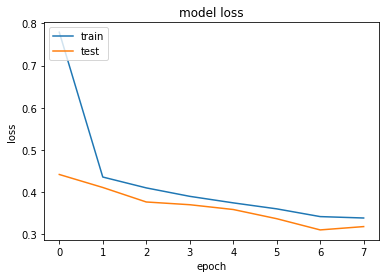

In [ ]:
# Plot the Accuracy and Loss Function
plot_charts(history)